In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, ratio_correction_factor
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_DIR = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/CORRELATORS'

# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'


BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [15]:
ENSEMBLE = 'MediumCoarse'
RATIO    = 'XF'
SMSLIST  = ['1S','RW']
# SMSLIST  = ['1S']
MOMLIST  = ['100','200','300','400']
# MOMLIST  = ['000']

In [16]:
if RATIO in ['RMINUS','RPLUS','QPLUS','XF']:
    meson = 'D'
else:
    meson = 'Dst'

In [17]:
TMIN    = 1
NSTATES = 2

In [18]:
JK = True

# ---------- chi^2_exp analysis -------------
# chi2_exp = 17.999999999999886 +/- 6.000000000000002 
# p-value [eval] = 0.7346
# p-value [MC]   = 0.7392000000000001
# ---------- 2+2 fit in (1, 9) for mes: XF of ens: MediumCoarse for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 0.23 [18]    Q = 1    logGBF = 86.058

Parameters:
        ratio 0   -0.0719 (13)      [ -0.07 (10) ]  
         A_1S 0      0.29 (39)      [    0 ± 1.0 ]  
              1    -0.477 (96)      [    0 ± 1.0 ]  
         B_1S 0     -0.29 (31)      [    0 ± 1.0 ]  
              1     0.015 (74)      [    0 ± 1.0 ]  
         A_RW 0     -0.50 (44)      [    0 ± 1.0 ]  
              1      0.30 (10)      [    0 ± 1.0 ]  
         B_RW 0     -0.44 (38)      [    0 ± 1.0 ]  
              1     0.079 (79)      [    0 ± 1.0 ]  
       dE_src 0      0.90 (42)      [  1.20 (50) ]  
              1     -0.56 (15)      [ -0.76 (50) ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time 

Text(0, 0.5, 'abs($x_f$)')

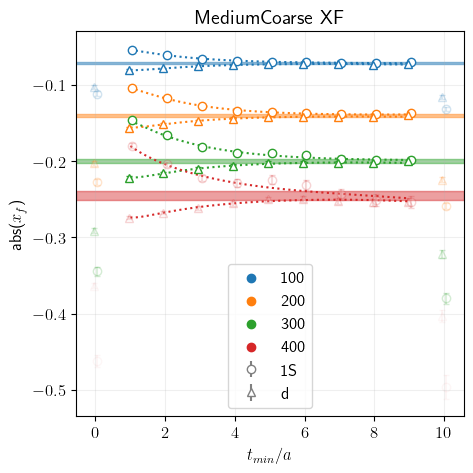

In [19]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,1,figsize=(5,5))

fits = []
f0s = []
for i,mom in enumerate(MOMLIST):
    requisites = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = JK
    )

    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)
    robj = RatioFitter(
        io,
        jkBin     = BINSIZE[ENSEMBLE],
        smearing  = SMSLIST,
        # readfrom  = DATA_2PT,
        **requisites
    )

    trange = (TMIN, robj.Ta-TMIN)

    cov_specs = dict(
        diag   = False,
        block  = False,
        scale  = True,
        shrink = True,
        cutsvd = 1E-12
    )

    dE_src = phys_energy_priors(ENSEMBLE,meson,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)

    fit = robj.fit(
        Nstates = NSTATES,
        trange  = trange,
        priors  = pr,
        verbose = False,
        **cov_specs
    )

    res = robj.fit_result(
        Nexc   = NSTATES,
        trange = trange,
        priors = pr 
    )

    fits.append({
        'ensemble': ENSEMBLE,
        'ratio'   : RATIO,
        'momentum': mom,
        'f0'      : fit.p['ratio'][0],
        'chiexp'  : res['chiexp'],
        'pstd'    : res['pstd']
    })


    alpha = 0.2 if mom=='400' else 1.
    robj.plot_fit(ax,NSTATES,trange,color=f'C{i}',color_res=f'C{i}',alpha=alpha,minus=False)

    ax.scatter([],[], marker='o', color=f'C{i}', label=mom)


    f0s.append(fit.p['ratio'][0])

ax.errorbar([],[],[],fmt='o', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='1S')
ax.errorbar([],[],[],fmt='^', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='d')

# ax.set_xlim(-0.5,13)
# ax.set_ylim(ymax=0.35,ymin=0.)
ax.grid(alpha=0.2)
ax.legend()

ax.set_xlabel(r'$t_{min}/a$')

ax.set_title(f'{ENSEMBLE} {RATIO}')

# ax.set_ylabel(r'$Q_+$')
ax.set_ylabel(r'abs($x_f$)')


# plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_{RATIO}_multimom.pdf')

In [70]:
print(pd.DataFrame(fits).set_index(['ensemble','ratio','momentum']))

                                   f0  chiexp      pstd
ensemble ratio  momentum                               
Fine-1   RMINUS 100       -0.0880(15)    32.0  0.943642
                200       -0.1790(38)    32.0  0.595768
                300       -0.2584(64)    32.0  0.486708
                400        -0.327(11)    32.0  0.405896
